In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas_profiling

import warnings 
warnings.filterwarnings('ignore')
#nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#import re
#import nltk

#from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

First, we need to import the piece of dataset as an example. It's data of New York Times from October 2022.

In [2]:
test = pd.read_csv('headlines/2022-10.csv')
#the example of the data
test.head()

headline  \
0  Facing a Dire Storm Forecast in Florida, Offic...   
1  North Korea Launches Two Ballistic Missiles, F...   
2                    Portraits of Flight From Russia   
3  Federal Judge Rules Against Fair Fight Action ...   
4                Florida details 23 deaths from Ian.   

                                            abstract  \
0  A day of hesitation in Lee County came despite...   
1  The test came a day after the United States, J...   
2  A mountain pass into Georgia has become a chok...   
3  A U.S. District Court judge found that the sec...   
4               The toll could take weeks to emerge.   

                                             snippet        date    doc_type  \
0  A day of hesitation in Lee County came despite...  2022-10-01     article   
1  The test came a day after the United States, J...  2022-10-01     article   
2  A mountain pass into Georgia has become a chok...  2022-10-01  multimedia   
3  A U.S. District Court judge found that the sec...  2022-10-01     article   
4               The toll could take weeks to emerge.  2022-10-01     article   

  material_type news_desk section_name subsection_name  word_count  \
0          News  National         U.S.             NaN        1479   
1          News   Foreign        World    Asia Pacific         604   
2     Slideshow  Homepage     Homepage             NaN           0   
3          News  National         U.S.        Politics         464   
4          News   Express         U.S.             NaN         218   

                                            keywords  \
0  ['Hurricane Ian (2022)', 'Deaths (Fatalities)'...   
1  ['Defense and Military Forces', 'Missiles and ...   
2                                                 []   
3  ['Decisions and Verdicts', 'Voting Rights, Reg...   
4                                                 []   

                                             web_url  
0  https://www.nytimes.com/2022/09/30/us/hurrican...  
1  https://www.nytimes.com/2022/09/30/world/asia/...  
2  https://www.nytimes.com/slideshow/2022/09/30/h...  
3  https://www.nytimes.com/2022/09/30/us/politics...  
4  https://www.nytimes.com/2022/09/30/us/hurrican...

A short overview of this data.

In [3]:
# shape of the dataset
print('The size of the dataset:',test.shape)
# total number of unique categories
print("Unique categories:",test['section_name'].nunique())
print("-------------------------------------------------")
# information about metadata
test.info()

The size of the dataset: (3857, 12)
Unique categories: 41
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 0 to 3856
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headline         3854 non-null   object
 1   abstract         3857 non-null   object
 2   snippet          3772 non-null   object
 3   date             3857 non-null   object
 4   doc_type         3857 non-null   object
 5   material_type    3856 non-null   object
 6   news_desk        3801 non-null   object
 7   section_name     3857 non-null   object
 8   subsection_name  1713 non-null   object
 9   word_count       3857 non-null   int64 
 10  keywords         3857 non-null   object
 11  web_url          3857 non-null   object
dtypes: int64(1), object(11)
memory usage: 361.7+ KB


In [4]:
#pip install Jinja2
# descrption of numerical variables of the dataset
test.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

Much more detailed overview - profiling.

In [5]:
test.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From profiling we can see how much observations we have (**3857**), and how much of missing values we have for the headlines (**3**), despite our effort not to include articles without headlines. Thus, we know that removing NULL values is necessary in data cleaning/preparation for vizualization. \
The only one numerical value is the word_count, and all others are categorical.\
Also, we see that abstract fields are more complete than snippets (missing values **0** vs **85**.) It can be useful when we decide what we want to include in our text analysis.\
Doc_type and material_type are highly correlated. 

We are especially interested in section_name category. Let us see how many articles in every section.

In [6]:
sec = test.groupby('section_name') #returns pandas groupby dataframe 
print("total categories:", sec.ngroups)
print(sec.size())

total categories: 41
section_name
Arts                           300
Books                          147
Briefing                       118
Business Day                   299
Climate                         33
Corrections                     30
Crosswords & Games              80
Education                       13
Fashion & Style                  1
Food                            79
Headway                          1
Health                          40
Homepage                         4
Job Market                       1
Magazine                        41
Movies                         110
Neediest Cases                   4
New York                       159
Obituaries                       7
Opinion                        310
Podcasts                        52
Real Estate                     96
Science                         40
Smarter Living                   3
Sports                         219
Style                          112
T Brand                          8
T Magazine           

In [7]:
sec.describe() #word_count statistics for each articles section

word_count                                    \
                                 count         mean          std     min   
section_name                                                               
Arts                             300.0  1038.133333   512.578754     0.0   
Books                            147.0  1076.054422   669.284517     0.0   
Briefing                         118.0  1258.745763   420.989761     0.0   
Business Day                     299.0   998.511706   557.792373     0.0   
Climate                           33.0  1091.757576   459.190458     0.0   
Corrections                       30.0   257.300000   147.094188    52.0   
Crosswords & Games                80.0   569.825000   437.836446   109.0   
Education                         13.0  1728.461538   917.884671   486.0   
Fashion & Style                    1.0   759.000000          NaN   759.0   
Food                              79.0   850.481013   411.389418     0.0   
Headway                            1.0  5290.000000          NaN  5290.0   
Health                            40.0  1220.300000   559.177977     0.0   
Homepage                           4.0     0.000000     0.000000     0.0   
Job Market                         1.0     0.000000          NaN     0.0   
Magazine                          41.0  2159.268293  2671.451048     0.0   
Movies                           110.0   746.054545   549.854090     0.0   
Neediest Cases                     4.0  1083.250000    55.427881  1017.0   
New York                         159.0  1177.679245   535.895870     0.0   
Obituaries                         7.0  1048.714286   543.479443     0.0   
Opinion                          310.0  1268.854839   826.817947     0.0   
Podcasts                          52.0  2001.346154  4408.537190     0.0   
Real Estate                       96.0   567.635417   630.819552     0.0   
Science                           40.0  1075.375000   474.400604   419.0   
Smarter Living                     3.0     0.000000     0.000000     0.0   
Sports                           219.0  1192.566210   577.965063     0.0   
Style                            112.0  1116.517857   785.867467     0.0   
T Brand                            8.0     0.000000     0.000000     0.0   
T Magazine                        36.0  1028.388889   919.693622     0.0   
Technology                        74.0  1021.243243   638.385695     0.0   
The Learning Network              88.0   730.693182   776.920022     0.0   
The New York Times Presents        1.0     0.000000          NaN     0.0   
The Upshot                        25.0   727.040000   678.939582     0.0   
Theater                           68.0  1004.323529   437.731344   261.0   
Times Insider                     13.0   764.538462   104.724731   565.0   
Today’s Paper                     30.0    47.900000     8.010123    31.0   
Travel                            26.0  1339.038462   779.962896     0.0   
U.S.                             578.0  1038.207612   602.242975     0.0   
Well                              38.0  1155.236842   534.477387     0.0   
World                            556.0   822.071942   515.311866     0.0   
Your Money                         6.0  1539.833333   967.385428   810.0   
en Español                        11.0   445.090909   177.394168     0.0   

                                                                
                                 25%     50%      75%      max  
section_name                                                    
Arts                          678.00  1089.0  1356.75   2681.0  
Books                         740.50  1067.0  1290.00   5067.0  
Briefing                     1249.00  1317.0  1513.25   1858.0  
Business Day                  499.50   973.0  1423.50   3598.0  
Climate                       929.00  1134.0  1383.00   1863.0  
Corrections                   160.00   227.5   360.50    537.0  
Crosswords & Games            165.00   550.0   921.00   1902.0  
Education                    1241

In [8]:
#more graphical representation of the word_count per section

#max words in articles
max = test.groupby('section_name')['word_count'].max().reset_index().sort_values(by='word_count',ascending=False)
max.head(10)

section_name  word_count
20     Podcasts       15636
14     Magazine        8783
19      Opinion        7010
36         U.S.        5808
10      Headway        5290
1         Books        5067
28   Technology        5009
17     New York        4978
38        World        4923
25        Style        4906

In [9]:
#min words in articles
min = test.groupby('section_name')['word_count'].min().reset_index().sort_values(by='word_count',ascending=False)
min.head()

section_name  word_count
10          Headway        5290
16   Neediest Cases        1017
39       Your Money         810
8   Fashion & Style         759
33    Times Insider         565

In [10]:
#mean words in the articles
mean = test.groupby('section_name')['word_count'].mean().reset_index().sort_values(by='word_count',ascending=False)
mean.head()

section_name   word_count
10      Headway  5290.000000
14     Magazine  2159.268293
20     Podcasts  2001.346154
7     Education  1728.461538
39   Your Money  1539.833333

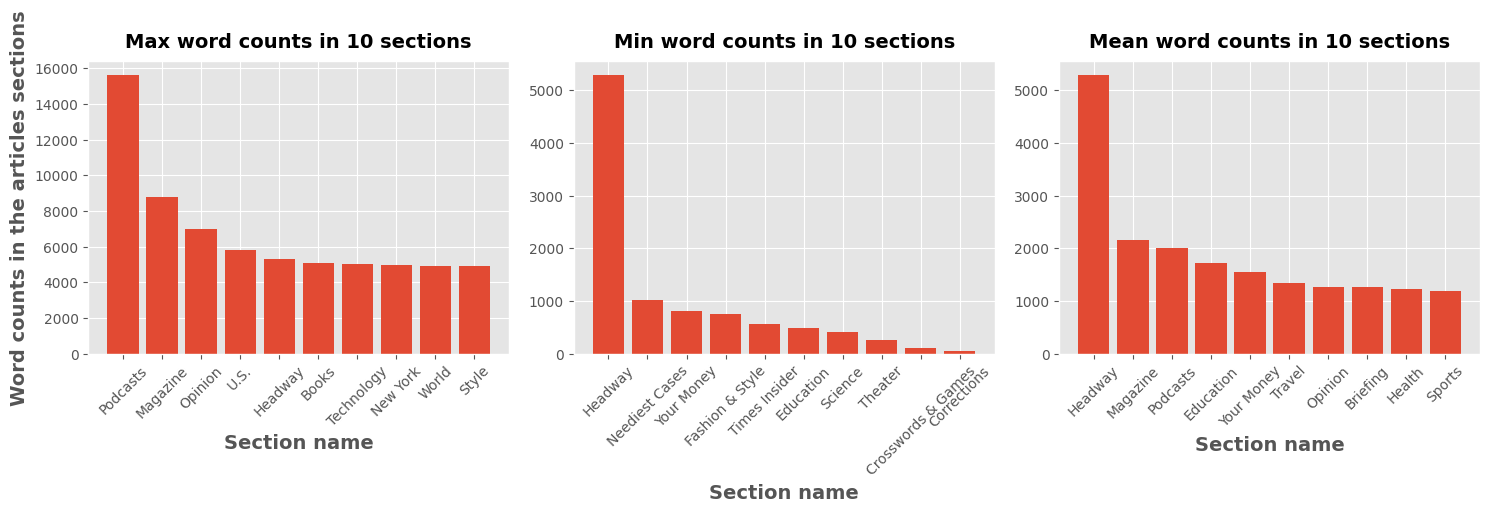

In [11]:
# plot the bar plots of max, mean and min length of articles in each section
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.bar(max['section_name'][:10], max['word_count'][:10])
plt.xticks(rotation=45)
plt.ylabel("Word counts in the articles sections", size=14)
plt.xlabel("Section name",  size=14)
plt.title("Max word counts in 10 sections", size=14)

plt.subplot(132)
plt.bar(min['section_name'][:10], min['word_count'][:10])
plt.xticks(rotation=45)
plt.xlabel("Section name", size=14)
plt.title("Min word counts in 10 sections", size=14)

plt.subplot(133)
plt.bar(mean['section_name'][:10], mean['word_count'][:10])
plt.xticks(rotation=45)
plt.xlabel("Section name", size=14)
plt.title("Mean word counts in 10 sections", size=14)

plt.show()

In [12]:
# Top sections by number of articles per section. 
ss = test['section_name'].value_counts()#returns pandas series 
#we convert in data frame
sd = pd.DataFrame({'section':ss.index, 'num':ss.values})
sd.head()

section  num
0          U.S.  578
1         World  556
2       Opinion  310
3          Arts  300
4  Business Day  299

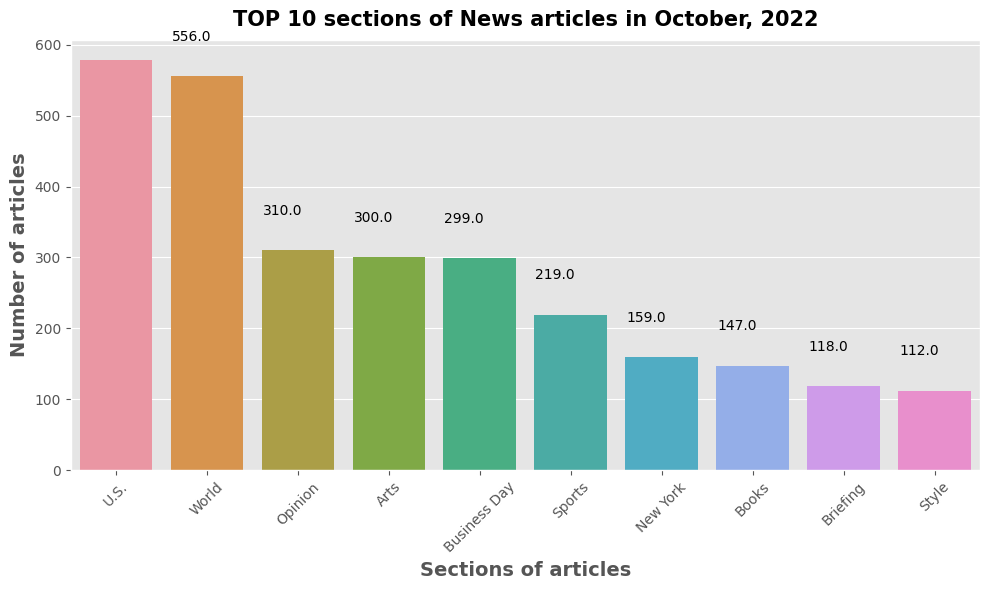

In [13]:
# Visualize top 10 sections and proportion of each section in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(data = sd, x = np.array(sd.section)[:10], y = np.array(sd.num)[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 10 sections of News articles in October, 2022", size=15)
plt.xlabel("Sections of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

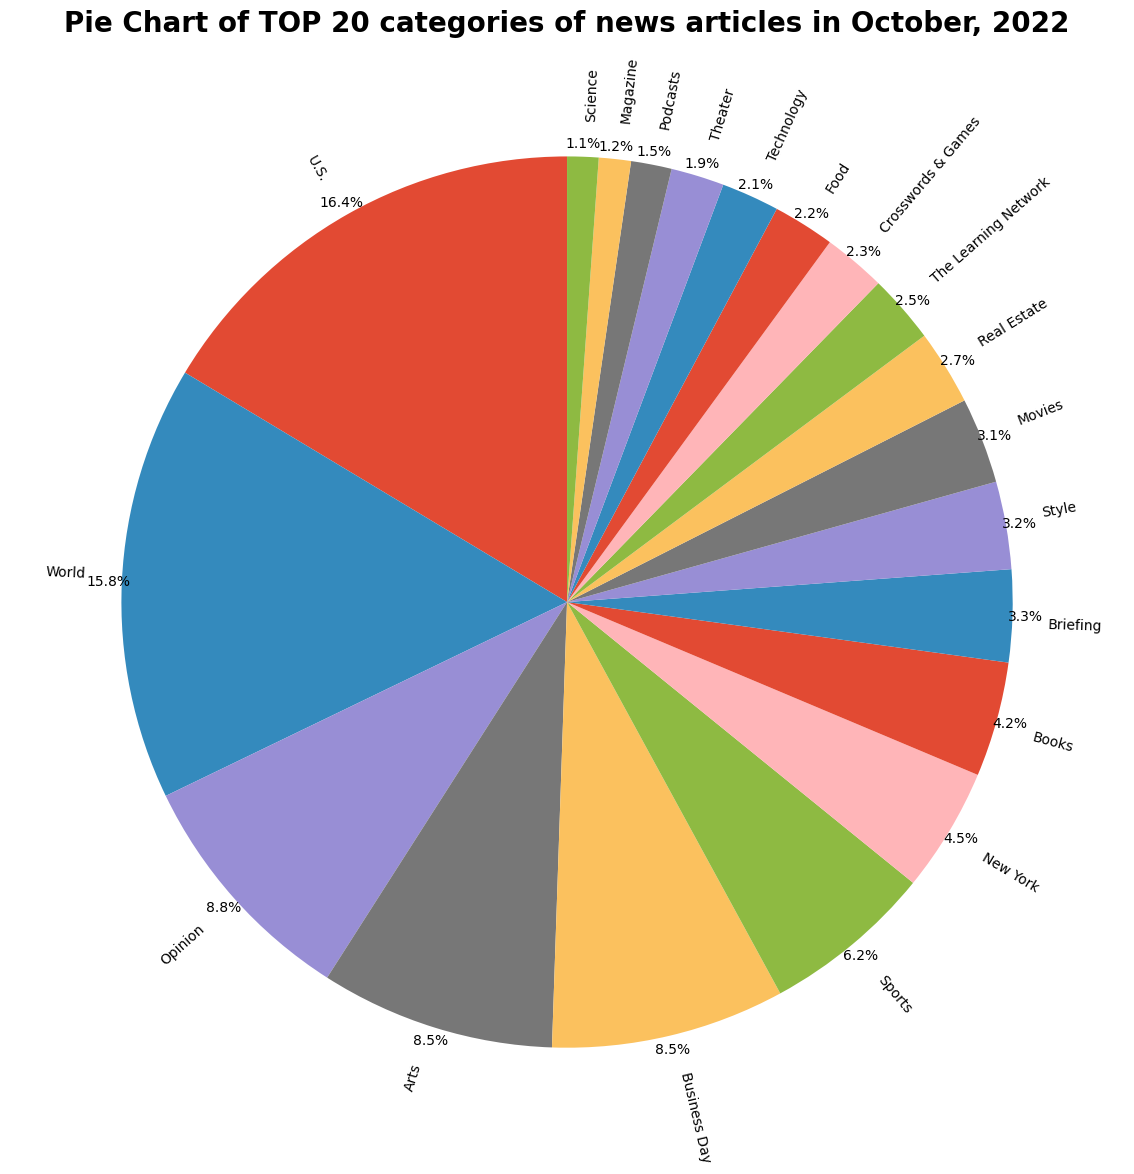

In [14]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(sd['num'][:20],
            labels=sd['section'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles in October, 2022", size=20, weight='bold')
plt.show()

(-0.5, 1599.5, 599.5, -0.5)

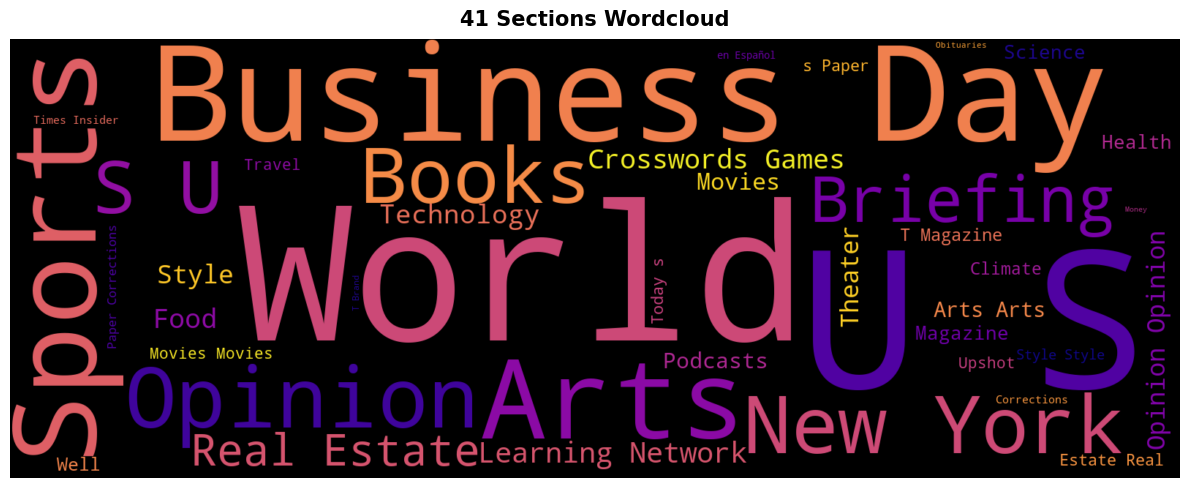

In [15]:

# wordcloud of sections in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(test.section_name))

plt.title("41 Sections Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

In [16]:
test_info = test[['headline', 'abstract', 'section_name']]
test_info['words'] = test_info['headline'] + ' ' + test_info['abstract']
#to check if any empty cells (columns)
test_info.isna().any()
# to check the rows
test_info[test_info.isna().any(axis=1)]
#take the rows which are not na
test_info = test_info[test_info['headline'].notna()]

In [17]:
test_info.shape #checking the dimensions of the resulting data set

(3854, 4)

In [22]:
# list of top 10 sections in out dataset
sections = sd['section'][:10].to_list()
# list of news articles of each top 10 categories list
articles_list = []

sections = sd['section'][:10].to_list()
for i in sections:
    cloud = test_info[test_info['section_name'] == i]
    word = cloud['words'].values
    articles_list.append(word)

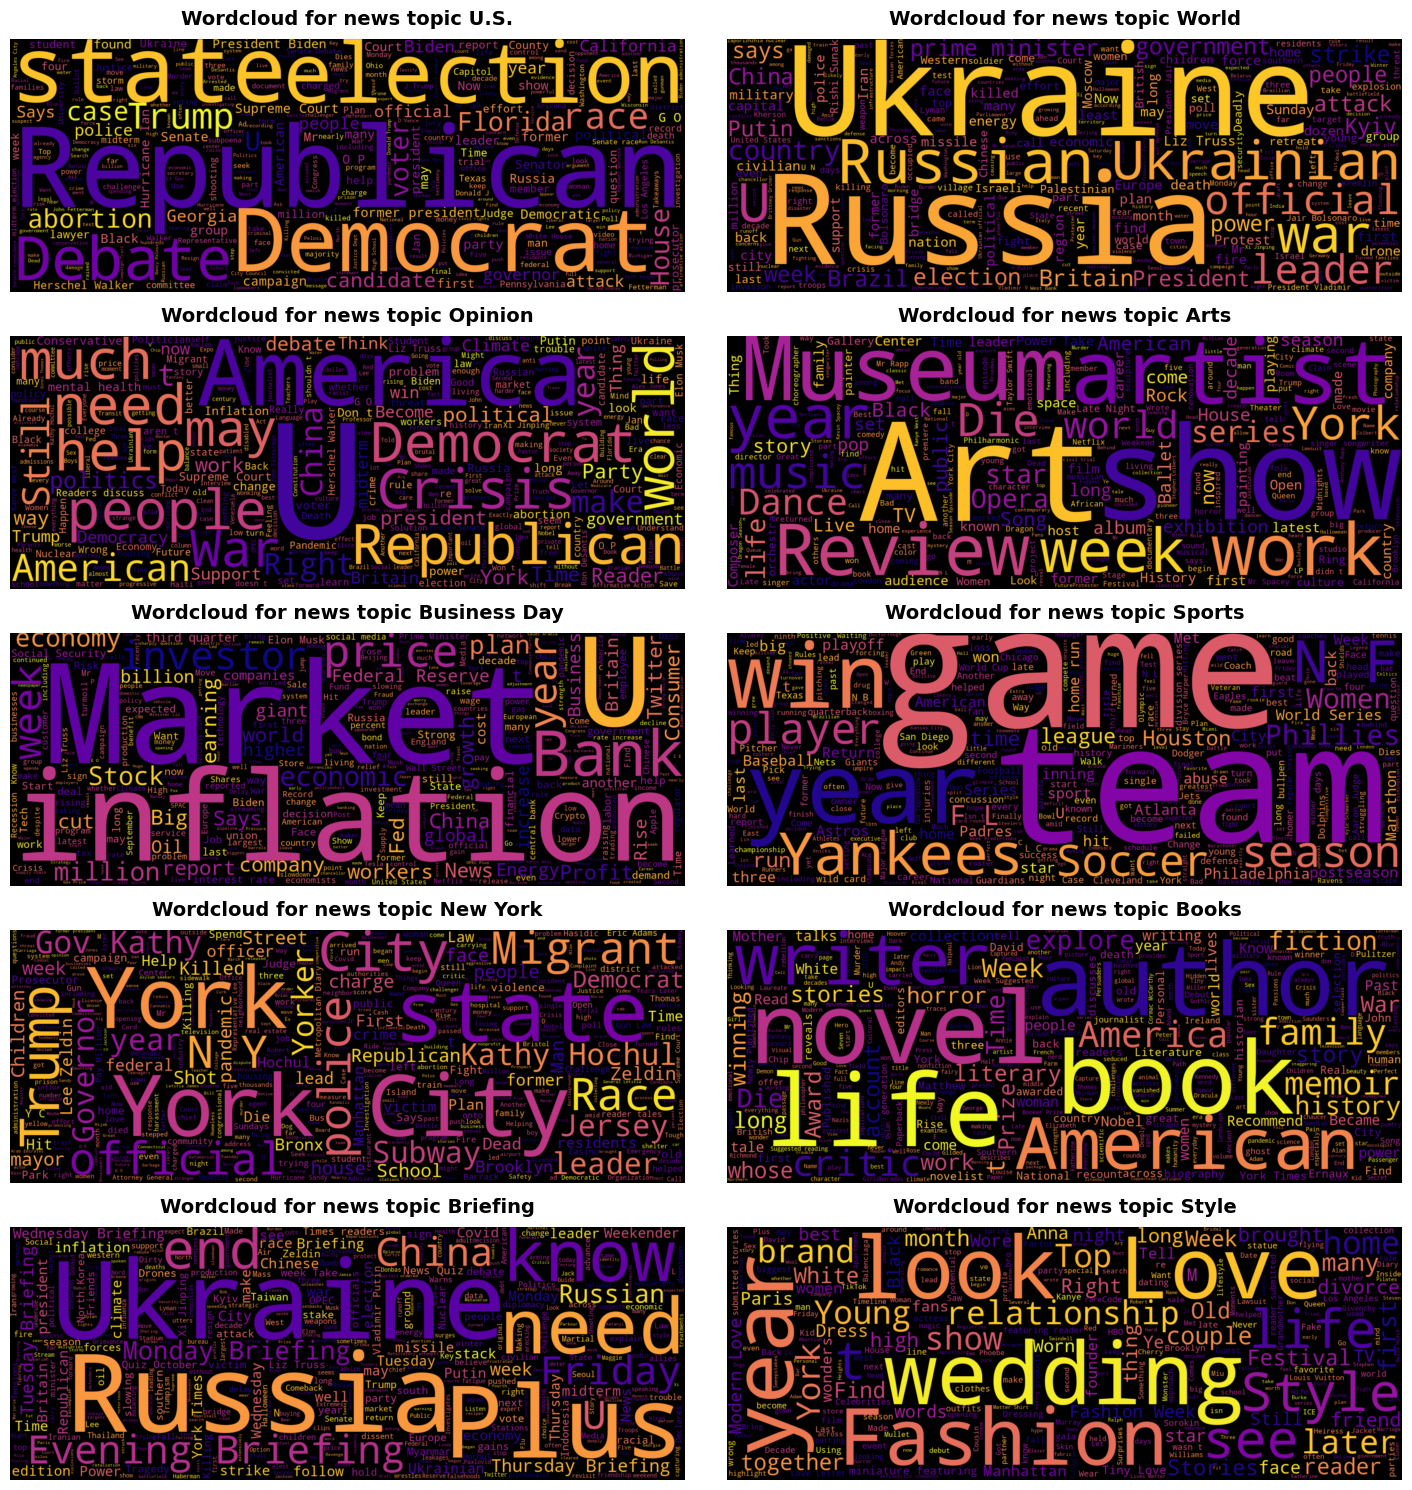

In [24]:
# create a wordcloud instance
stopwords = set(STOPWORDS)
stopwords.update(['will', 'new', 'said', 'day', 'one', 'two', 'say', 's'])
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=stopwords)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(sections):
    plt.subplot(5,2,idx+1)
    cloud_of_words = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud_of_words, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

Now let's look at the articles from much older times.

In [20]:
test2 = pd.read_csv('headlines/1922-10.csv')
test2.head()

headline  \
0  MUHLENBERG EASY FOR ORANGE ELEVEN; Syracuse Sc...   
1  ALLIANCE NOT INTERESTED.; Textile Body Knows N...   
2  BOOM ON 125TH STREET.; Conditions Better Than ...   
3                      A RUSSIAN REFUGEE ON AMERICA.   
4  1,000 BABIES PARADE IN HISTORIC DRESS; East Si...   

                                            abstract  snippet        date  \
0                                                NaN      NaN  1922-10-01   
1                                                NaN      NaN  1922-10-01   
2  At no time in its history has 125th Street bee...      NaN  1922-10-01   
3                                                NaN      NaN  1922-10-01   
4  A neighborhood epic unequaled in the history o...      NaN  1922-10-01   

  doc_type material_type news_desk section_name  subsection_name  word_count  \
0  article      Archives      None     Archives              NaN           0   
1  article      Archives      None     Archives              NaN           0   
2  article      Archives      None     Archives              NaN           0   
3  article      Archives      None     Archives              NaN           0   
4  article      Archives      None     Archives              NaN           0   

  keywords                                            web_url  
0       []  https://www.nytimes.com/1922/10/01/archives/mu...  
1       []  https://www.nytimes.com/1922/10/01/archives/al...  
2       []  https://www.nytimes.com/1922/10/01/archives/bo...  
3       []  https://www.nytimes.com/1922/10/01/archives/a-...  
4       []  https://www.nytimes.com/1922/10/01/archives/10...

In [21]:
# shape of the dataset
print('The size of the dataset:',test2.shape)
# total number of unique categories
print("Unique categories:",test2['section_name'].nunique())
print("-------------------------------------------------")
# information about metadata
test2.info()

The size of the dataset: (8905, 12)
Unique categories: 1
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8905 entries, 0 to 8904
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   headline         8905 non-null   object 
 1   abstract         3894 non-null   object 
 2   snippet          0 non-null      float64
 3   date             8905 non-null   object 
 4   doc_type         8905 non-null   object 
 5   material_type    8905 non-null   object 
 6   news_desk        8901 non-null   object 
 7   section_name     8905 non-null   object 
 8   subsection_name  0 non-null      float64
 9   word_count       8905 non-null   int64  
 10  keywords         8905 non-null   object 
 11  web_url          8905 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 835.0+ KB
